# Prática 1

## Inferência Bayesiana

***Estatística para Ciência de Dados***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**






### Exercício:

Na aplicação de dados bancários que vimos na Aula 1 (clientes do banco), considere diferentes tamanhos de amostra e diferentes prioris e veja como interferem na posteriori.

Além disso, altere os parâmetros da distribuição a priori (chamados **hiperparâmetros**) e verifique os efeitos na distribuição a posteriori.

Considere, por exemplo, uma distribuição a priori beta para a proporção p, com diferentes hiperparâmetros. Compare os resultados com os obtidos com uma distribuição a priori uniforme para p.

### Exemplo de priori conjugada beta-Bernoulli

Ver https://towardsdatascience.com/conjugate-prior-explained-75957dc80bfb



No exemplo do banco, se considerarmos que


- $X=\left\{ \begin{array}{lll} 1, &\mbox{se o cliente é classificado como inadimplente,} \\ 0, &\mbox{caso contrário.} \end{array}\right.$


- $X \sim Bernoulli(p)$


- Verossimilhança:

Para $n$ suficientemente grande, pelo TLC sabemos que a distribuição amostral de $\bar{X}$ se aproxima da normal $$\bar{X} \sim N\left(p, \displaystyle{\frac{p(1-p)}{n}}\right)$$


Além disso, $Y = \sum_{i=1}^{n} X_i \sim binomial(np, np(1-p))$.





In [1]:
import pandas as pd

# Dados banco - Leitura dos dados
dados = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/Estatistica-Ciencia-Dados/main/Data/dados_banco.csv', index_col=0)

dados.head()

,Sexo,Idade,Empresa,Salario,Saldo_cc,Saldo_poupança,Saldo_investimento,Devedor_cartao,Inadimplente
Cliente,,,,,,,,,
75928,M,32,Privada,5719.00,933.79,0.0,0.0,6023.68,0
52921,F,28,Privada,5064.00,628.37,0.0,0.0,1578.24,0
8387,F,24,Autônomo,4739.00,889.18,0.0,0.0,2578.70,0
54522,M,30,Pública,5215.00,1141.47,0.0,0.0,4348.96,0
45397,M,30,Autônomo,5215.56,520.70,0.0,0.0,1516.78,1


**Considere diferentes tamanhos de amostra. Como interferem na posteriori?**

In [2]:
# Vamos trabalhar com uma amostra
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import random

a = 2
b = 8

amostra = dados.sample(n=500, replace=False, random_state=10)

n = len(amostra)
k = amostra['Inadimplente'].sum()
posteriori = beta(a + k, n - k + b)

k/n

0.268

**Considere diferentes tipos de priori, por exemplo beta ou uniforme. Como interferem na posteriori?**

## Priori 1 - beta

- Priori: $p \sim beta(2, 8)$


- Posteriori: $p|k \sim beta(k+a, n-k+b)$

onde $k$ é o número de sucessos observados na amostra.


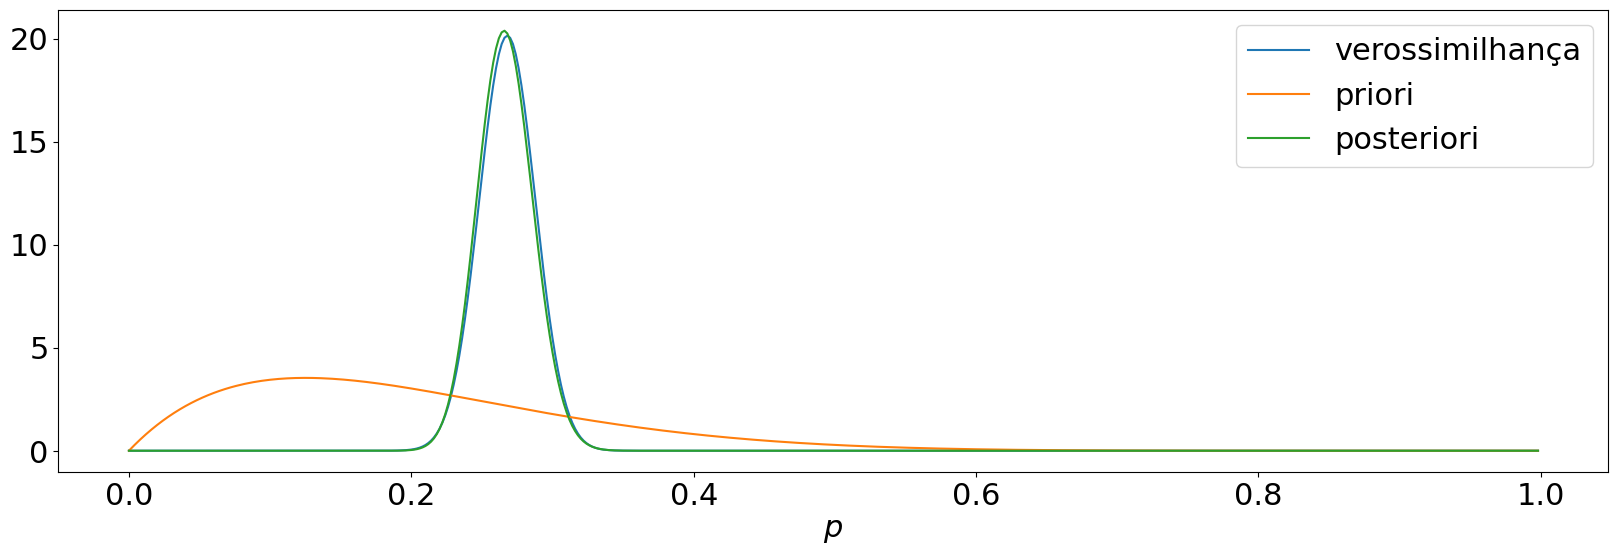

In [3]:
from scipy.stats import norm

# Eixo x entre 0 e 1 de .002 em .002.
x_axis = np.arange(0, 1, 0.002)

# Plota as densidades da beta para cada conjunto de parâmetros
plt.figure(figsize=(20,6))

prior = beta(a, b)

p_chapeu = amostra['Inadimplente'].mean()
dp = np.sqrt(p_chapeu*(1-p_chapeu)/n)

media = p_chapeu
dp = np.sqrt(media*(1-media)/n)

plt.s = 0
plt.rcParams.update({'font.size': 22})

plt.plot(x_axis, norm.pdf(x_axis, media, dp), label='verossimilhança')
plt.plot(x_axis, prior.pdf(x_axis), label='priori')
plt.plot(x_axis, posteriori.pdf(x_axis), label='posteriori')
plt.xlabel(r'$p$')
plt.legend()


In [4]:
# Estimador bayesiano EAP (Esperança a posteriori)
print('Média: %.2f' % posteriori.mean())


# E para calcular um intervalo de credibilidade, decidimos uma probabilidade
# Por exemplo 95% para a credibilidade
# Uma maneira seria definir que 2,5% de cada cauda como os limites do intervalo (chamado intervalo simétrico)
# Este método é válido quando a posteriori se aproxima de uma distribuição simétrica, pois nesse caso tende a gerar o intervalo com menor amplitude
# A seguir, apresentamos outra solução com um intervalo de credibilidade de menor amplitude.

LI = posteriori.ppf(.025)
LS = posteriori.ppf(.975)
print("Intervalo com 95% de credibilidade: {:.3f}, {:.3f})".format(LI,LS))


Média: 0.27
Intervalo com 95% de credibilidade: 0.229, 0.306)


## Exemplos




In [5]:
#!pip install pymc3==3.11.1


In [6]:
!pip install theano
!pip install arviz==0.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668109 sha256=0ec2cc632f309da8c0d0ea5c63bb2d89c6a250d66c156c0f39af9799facdf31b
  Stored in directory: /root/.cache/pip/wheels/d9/e6/7d/2267d21a99e4ab8276f976f293b4ff23f50c9d809f4a216ebb
Successfully built theano


In [7]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm




## Modelo beta-Bernoulli: clientes do banco

Com amostra de 500 observações, considere, por exemplo, priori beta (10,5). Compare com os resultados obtidos em aula.

In [8]:
with pm.Model() as model:
    p = pm.Beta("p", 10, 5)
    obs = pm.distributions.discrete.Bernoulli("obs", p, observed=amostra['Inadimplente'])

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)


In [9]:
az.summary(idata)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.279,0.02,0.242,0.316,0.0,0.0,1764.0,2912.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


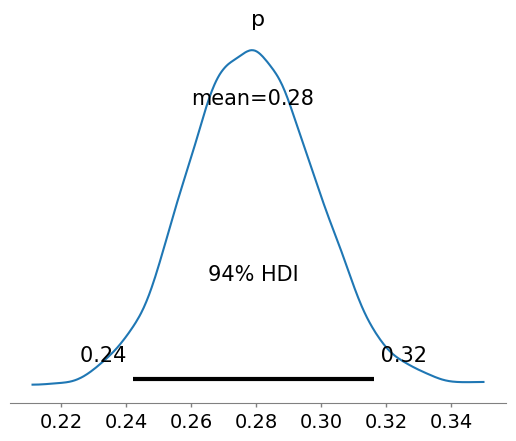

In [10]:
az.plot_posterior(idata);


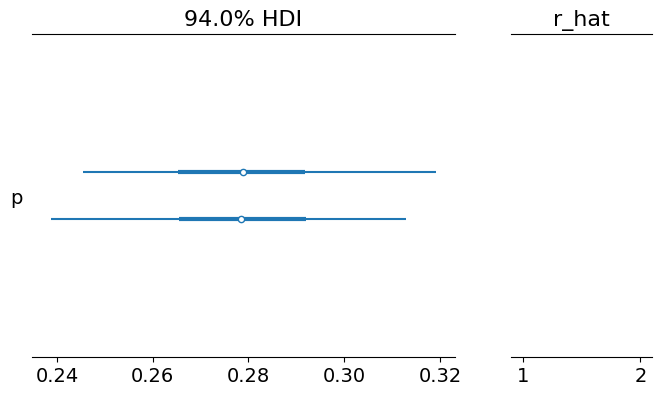

In [11]:
az.plot_forest(idata, r_hat=True);

### Análise de resultados

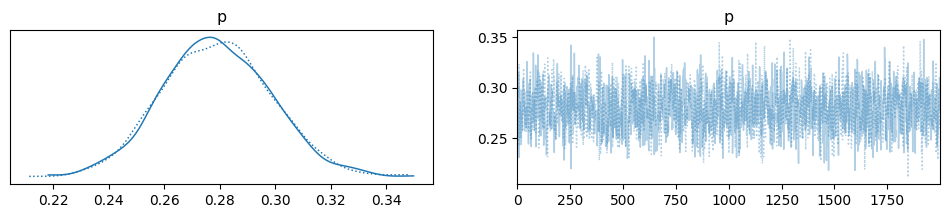

In [12]:
az.plot_trace(idata);


In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.279,0.02,0.242,0.316,0.0,0.0,1764.0,2912.0,1.0


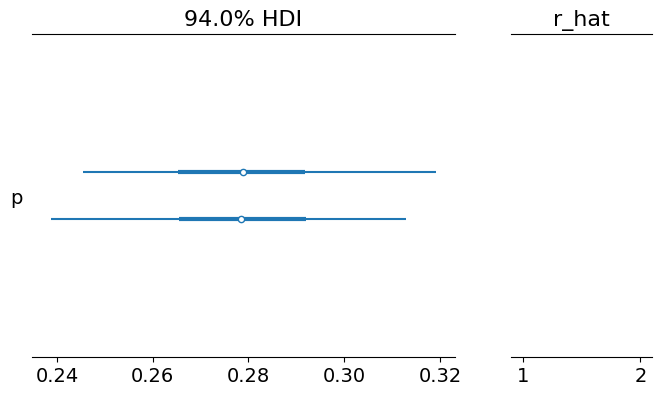

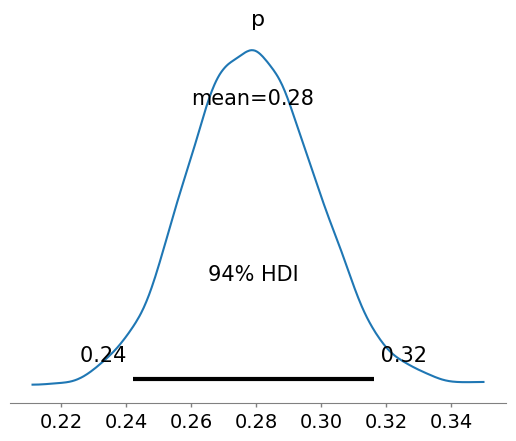

In [14]:
az.plot_forest(idata, r_hat=True);

az.plot_posterior(idata);


## Priori uniforme

Considere agora, por exemplo, priori uniforme para a proporção p. Como interfere na posteriori?

**Refaça as análises com diferentes tamanhos de amostra, por exemplo 100 ou 10000.**

In [15]:
with pm.Model() as model:
    p = pm.Uniform("p")
    obs = pm.distributions.discrete.Bernoulli("obs", p, observed=amostra['Inadimplente'])

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)



In [16]:
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.269,0.019,0.236,0.307,0.0,0.0,1598.0,2624.0,1.0


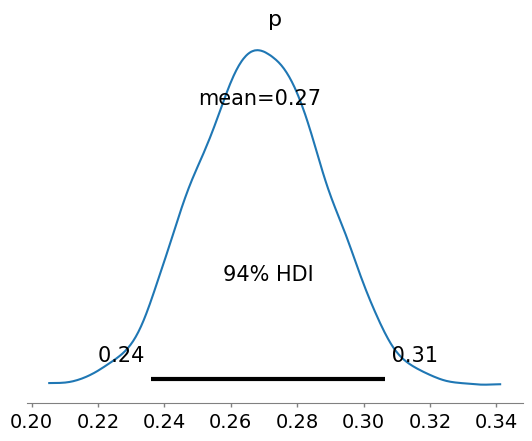

In [17]:
az.plot_posterior(idata);


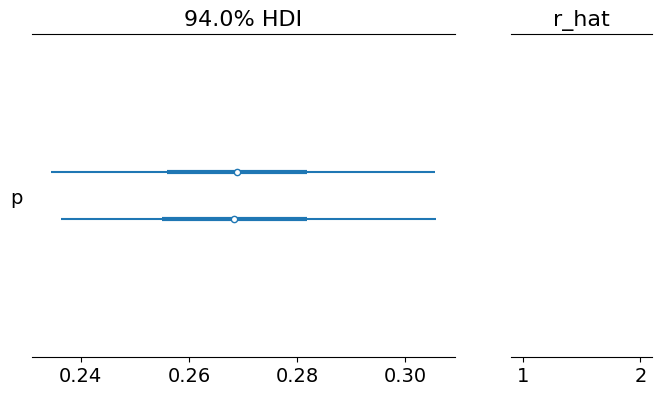

In [18]:
az.plot_forest(idata, r_hat=True);


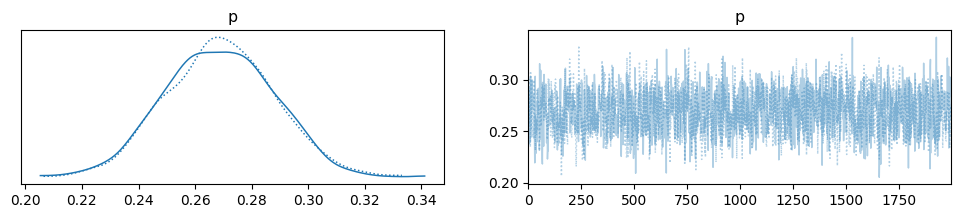

In [19]:

### Análise de resultados

az.plot_trace(idata);



In [20]:

az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.269,0.019,0.236,0.307,0.0,0.0,1598.0,2624.0,1.0


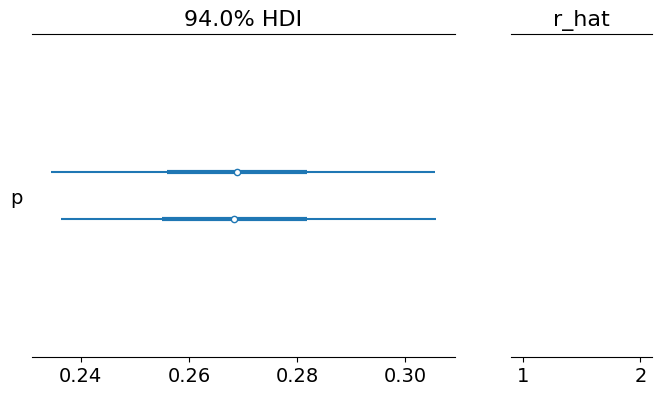

In [21]:

az.plot_forest(idata, r_hat=True);


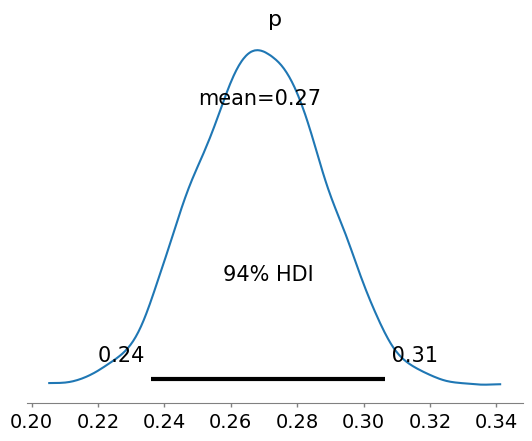

In [22]:

az.plot_posterior(idata);
